# Pragmatic color describers

In [1]:
__author__ = "Christopher Potts"
__version__ = "CS224u, Stanford, Spring 2020"

## Contents

1. [Overview](#Overview)
1. [Set-up](#Set-up)
1. [The corpus](#The-corpus)
  1. [Corpus reader](#Corpus-reader)
  1. [ColorsCorpusExample instances](#ColorsCorpusExample-instances)
    1. [Displaying examples](#Displaying-examples)
    1. [Color representations](#Color-representations)
    1. [Utterance texts](#Utterance-texts)
  1. [Far, Split, and Close conditions](#Far,-Split,-and-Close-conditions)
1. [Toy problems for development work](#Toy-problems-for-development-work)
1. [Core model](#Core-model)
  1. [Toy dataset illustration](#Toy-dataset-illustration)
  1. [Predicting sequences](#Predicting-sequences)
  1. [Listener-based evaluation](#Listener-based-evaluation)
  1. [Other prediction and evaluation methods](#Other-prediction-and-evaluation-methods)
  1. [Cross-validation](#Cross-validation)
1. [Baseline SCC model](#Baseline-SCC-model)
1. [Modifying the core model](#Modifying-the-core-model)
  1. [Illustration: LSTM Cells](#Illustration:-LSTM-Cells)
  1. [Illustration: Deeper models](#Illustration:-Deeper-models)

## Overview

This notebook is part of our unit on grounding. It illustrates core concepts from the unit, and it provides useful background material for the associated homework and bake-off.

## Set-up

In [2]:
from colors import ColorsCorpusReader
import os
import pandas as pd
from sklearn.model_selection import train_test_split
import torch
from torch_color_describer import (
    ContextualColorDescriber, create_example_dataset)
import utils
from utils import START_SYMBOL, END_SYMBOL, UNK_SYMBOL

In [3]:
utils.fix_random_seeds()

The [Stanford English Colors in Context corpus](https://cocolab.stanford.edu/datasets/colors.html) (SCC) is included in the data distribution for this course. If you store the data in a non-standard place, you'll need to update the following:

In [4]:
COLORS_SRC_FILENAME = os.path.join(
    "data", "colors", "filteredCorpus.csv")

## The corpus

The SCC corpus is based in a two-player interactive game. The two players share a context consisting of three color patches, with the display order randomized between them so that they can't use positional information when communicating.

The __speaker__ is privately assigned a target color and asked to produce a description of it that will enable the __listener__ to identify the speaker's target. The listener makes a choice based on the speaker's message, and the two  succeed if and only if the listener identifies the target correctly.

In the game, the two players played repeated reference games and could communicate with each other in a free-form way. This opens up the possibility of modeling these repeated interactions as task-oriented dialogues. However, for this unit, we'll ignore most of this structure. We'll treat the corpus as a bunch of independent reference games played by anonymous players, and we will ignore the listener and their choices entirely.

For the bake-off, we will be distributing a separate test set. Thus, all of the data in the SCC can be used for exploration and development.

### Corpus reader

The corpus reader class is `ColorsCorpusReader` in `colors.py`. The reader's primary function is to let you iterate over corpus examples:

In [5]:
corpus = ColorsCorpusReader(
    COLORS_SRC_FILENAME,
    word_count=None, 
    normalize_colors=True)

The two keyword arguments have their default values here. 

* If you supply `word_count` with an interger value, it will restrict to just examples where the utterance has that number of words (using a whitespace heuristic). This creates smaller corpora that are useful for development.

* The colors in the corpus are in [HLS format](https://en.wikipedia.org/wiki/HSL_and_HSV). With `normalize_colors=False`, the first (hue) value is an integer between 1 and 360 inclusive, and the L (lightness) and S (saturation) values are between 1 and 100 inclusive. With `normalize_colors=True`, these values are all scaled to between 0 and 1 inclusive. The default is `normalize_colors=True` because this is a better choice for all the machine learning models we'll consider.

In [6]:
examples = list(corpus.read())

We can verify that we read in the same number of examples as reported in [Monroe et al. 2017](https://transacl.org/ojs/index.php/tacl/article/view/1142):

In [7]:
# Should be 46994:

len(examples)

46994

### ColorsCorpusExample instances

The examples are `ColorsCorpusExample` instances:

In [8]:
ex1 = next(corpus.read())

These objects have a lot of attributes and methods designed to help you study the corpus and use it for our machine learning tasks. Let's review some highlights.

#### Displaying examples

You can see what the speaker saw, with the utterance they chose wote above the patches:

The darker blue one


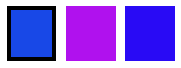

In [9]:
ex1.display(typ='speaker')

This is the original order of patches for the speaker. The target happens to the be the leftmost patch, as indicated by the black box around it.

Here's what the listener saw, with the speaker's message printed above the patches:

The darker blue one


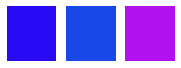

In [10]:
ex1.display(typ='listener')

The listener isn't shown the target, of course, so no patches are highlighted.

If `display` is called with no arguments, then the target is placed in the final position and the other two are given in an order determined by the corpus metadata:

The darker blue one


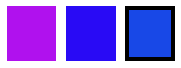

In [11]:
ex1.display()

This is the representation order we use for our machine learning models.

#### Color representations

For machine learning, we'll often need to access the color representations directly. The primary attribute for this is `colors`:

In [12]:
ex1.colors

[[0.7861111111111111, 0.5, 0.87],
 [0.6888888888888889, 0.5, 0.92],
 [0.6277777777777778, 0.5, 0.81]]

In this display order, the third element is the target color and the first two are the distractors. The attributes `speaker_context` and `listener_context` return the same colors but in the order that those players saw them. For example:

In [13]:
ex1.speaker_context

[[0.6277777777777778, 0.5, 0.81],
 [0.7861111111111111, 0.5, 0.87],
 [0.6888888888888889, 0.5, 0.92]]

#### Utterance texts

Utterances are just strings: 

In [14]:
ex1.contents

'The darker blue one'

There are cases where the speaker made a sequences of utterances for the same trial. We follow [Monroe et al. 2017](https://transacl.org/ojs/index.php/tacl/article/view/1142) in concatenating these into a single utterances. To preserve the original information, the individual turns are separated by `" ### "`. Example 3 is the first with this property – let's check it out:

In [15]:
ex3 = examples[2]

In [16]:
ex3.contents

'Medium pink ### the medium dark one'

The method `parse_turns` will parse this into individual turns:

In [17]:
ex3.parse_turns()

['Medium pink', 'the medium dark one']

For examples consisting of a single turn, `parse_turns` returns a list of length 1:

In [18]:
ex1.parse_turns()

['The darker blue one']

### Far, Split, and Close conditions

The SCC contains three conditions:
    
__Far condition__: All three colors are far apart in color space.  Example:

Condition type: far
purple


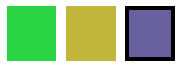

In [19]:
print("Condition type:", examples[1].condition)

examples[1].display()

__Split condition__: The target is close to one of the distractors, and the other is far away from both of them. Example:

Condition type: split
lime


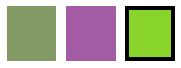

In [20]:
print("Condition type:", examples[3].condition)

examples[3].display()

__Close condition__: The target is similar to both distractors. Example:

Condition type: close
Medium pink ### the medium dark one


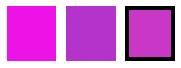

In [21]:
print("Condition type:", examples[2].condition)

examples[2].display()

These conditions go from easiest to hardest when it comes to reliable communication. In the __Far__ condition, the context is hardly relevant, whereas the nature of the distractors reliably shapes the speaker's choices in the other two conditions. 

You can begin to see how this affects speaker choices in the above examples: "purple" suffices for the __Far__ condition, a more marked single word ("lime") suffices in the __Split__ condition, and the __Close__ condition triggers a pretty long, complex description.

The `condition` attribute provides access to this value: 

In [22]:
ex1.condition

'close'

The following verifies that we have the same number of examples per condition as reported in [Monroe et al. 2017](https://transacl.org/ojs/index.php/tacl/article/view/1142):

In [23]:
pd.Series([ex.condition for ex in examples]).value_counts()

far      15782
split    15693
close    15519
dtype: int64

## Toy problems for development work

The SCC corpus is fairly large and quite challenging as an NLU task. This means it isn't ideal when it comes to testing hypotheses and debugging code. Poor performance could trace to a mistake, but it could just as easily trace to the fact that the problem is very challenging from the point of view of optimization.

To address this, the module `torch_color_describer.py` includes a function `create_example_dataset` for creating small, easy datasets with the same basic properties as the SCC corpus.

Here's a toy problem containing just six examples:

In [24]:
tiny_contexts, tiny_words, tiny_vocab = create_example_dataset(
    group_size=2, vec_dim=2)

In [25]:
tiny_vocab

['<s>', '</s>', 'A', 'B', '$UNK']

In [26]:
tiny_words

[['<s>', 'A', '</s>'],
 ['<s>', 'A', '</s>'],
 ['<s>', 'A', 'B', '</s>'],
 ['<s>', 'A', 'B', '</s>'],
 ['<s>', 'B', 'A', 'B', 'A', '</s>'],
 ['<s>', 'B', 'A', 'B', 'A', '</s>']]

In [27]:
tiny_contexts

[[array([0.84464215, 0.94729424]),
  array([0.5353399 , 0.57843591]),
  array([0.00500215, 0.05500586])],
 [array([0.80595944, 0.84372759]),
  array([0.50107106, 0.40530719]),
  array([0.01738777, 0.08438436])],
 [array([0.88390396, 0.88984181]),
  array([0.05563814, 0.17386006]),
  array([0.54320392, 0.54026499])],
 [array([0.88452288, 0.85557427]),
  array([0.04306275, 0.15269883]),
  array([0.55176147, 0.43193186])],
 [array([0.56949887, 0.52074521]),
  array([0.16142565, 0.14594636]),
  array([0.81854917, 0.81934328])],
 [array([0.47570688, 0.51040813]),
  array([0.16588093, 0.12370395]),
  array([0.90724562, 0.99462315])]]

Each member of `tiny_contexts` contains three vectors.  The final (target) vector always has values in a range that determines the corresponding word sequence, which is drawn from a set of three fixed sequences. Thus, the model basically just needs to learn to ignore the distractors and find the association between the target vector and the corresponding sequence. 

All the models we study have a capacity to solve this task with very little data, so you should see perfect or near perfect performance on reasonably-sized versions of this task.

## Core model

Our core model for this problem is implemented in `torch_color_describer.py` as `ContextualColorDescriber`. At its heart, this is a pretty standard encoder–decoder model:

* `Encoder`: Processes the color contexts as a sequence. We always place the target in final position so that it is closest to the supervision signals that we get when decoding.

* `Decoder`: A neural language model whose initial hidden representation is the final hidden representation of the `Encoder`.

* `EncoderDecoder`: Coordinates the operations of the `Encoder` and `Decoder`.

Finally, `ContextualColorDescriber` is a wrapper around these model components. It handle the details of training and implements the prediction and evaluation functions that we will use.

Many additional details about this model are included in the slides for this unit.

### Toy dataset illustration

To highlight the core functionality of `ContextualColorDescriber`, let's create a small toy dataset and use it to train and evaluate a model:

In [28]:
toy_color_seqs, toy_word_seqs, toy_vocab = create_example_dataset(
    group_size=50, vec_dim=2)

In [29]:
toy_color_seqs_train, toy_color_seqs_test, toy_word_seqs_train, toy_word_seqs_test = \
    train_test_split(toy_color_seqs, toy_word_seqs)

Here we expose all of the available parameters with their default values:

In [30]:
toy_mod = ContextualColorDescriber(
    toy_vocab, 
    embedding=None,  # Option to supply a pretrained matrix as an `np.array`.
    embed_dim=10, 
    hidden_dim=10, 
    max_iter=100, 
    eta=0.01,
    optimizer=torch.optim.Adam,
    batch_size=128,
    l2_strength=0.0,
    warm_start=False,
    device=None)

Using cuda


In [31]:
_ = toy_mod.fit(toy_color_seqs_train, toy_word_seqs_train)

Encoder cuda
Decoder cuda
EncoderDecoder cuda
Epoch 1; train err = 1.6837888956069946; time = 0.3410778045654297
Epoch 2; train err = 1.6837891340255737; time = 0.019005775451660156
Epoch 3; train err = 1.6837888956069946; time = 0.02401423454284668
Epoch 4; train err = 1.6837892532348633; time = 0.019012928009033203
Epoch 5; train err = 1.6837892532348633; time = 0.019003868103027344
Epoch 6; train err = 1.6837892532348633; time = 0.022005319595336914
Epoch 7; train err = 1.6837892532348633; time = 0.01900315284729004
Epoch 8; train err = 1.6837890148162842; time = 0.01900482177734375
Epoch 9; train err = 1.6837888956069946; time = 0.0200045108795166
Epoch 10; train err = 1.6837892532348633; time = 0.019004106521606445
Epoch 11; train err = 1.6837892532348633; time = 0.02200460433959961
Epoch 12; train err = 1.6837893724441528; time = 0.020006418228149414
Epoch 13; train err = 1.6837891340255737; time = 0.02100348472595215
Epoch 14; train err = 1.6837892532348633; time = 0.02700662612

### Predicting sequences

The `predict` method takes a list of color contexts as input and returns model descriptions:

In [32]:
toy_preds = toy_mod.predict(toy_color_seqs_test)

In [33]:
toy_preds[0]

['<s>',
 '$UNK',
 '$UNK',
 '$UNK',
 '$UNK',
 '$UNK',
 '$UNK',
 '$UNK',
 '$UNK',
 '$UNK',
 '$UNK',
 '$UNK',
 '$UNK',
 '$UNK',
 '$UNK',
 '$UNK',
 '$UNK',
 '$UNK',
 '$UNK',
 '$UNK']

We can then check that we predicted all correct sequences:

In [34]:
toy_correct = sum(1 for x, p in zip(toy_word_seqs_test, toy_preds))

toy_correct / len(toy_word_seqs_test)

1.0

For real problems, this is too stringent a requirement, since there are generally many equally good descriptions. This insight gives rise to metrics like [BLEU](https://en.wikipedia.org/wiki/BLEU), [METEOR](https://en.wikipedia.org/wiki/METEOR), [ROUGE](https://en.wikipedia.org/wiki/ROUGE_(metric)), [CIDEr](https://arxiv.org/pdf/1411.5726.pdf), and others, which seek to relax the requirement of an exact match with the test sequence. These are reasonable options to explore, but we will instead adopt a communcation-based evaluation, as discussed in the next section.

### Listener-based evaluation

`ContextualColorDescriber` implements a method `listener_accuracy` that we will use for our primary evaluations in the assignment and bake-off. The essence of the method is that we can calculate

$$
c^{*} = \text{argmax}_{c \in C} P_S(\text{utterance} \mid c)
$$


where $P_S$ is our describer model and $C$ is the set of all permutations of all three colors in the color context. We take $c^{*}$ to be a correct prediction if it is one where the target is in the privileged final position. (There are two such contexts; we try both in case the order of the distractors influences the predictions, and the model is correct if one of them has the highest probability.)

Here's the listener accuracy of our toy model:

In [35]:
toy_mod.listener_accuracy(toy_color_seqs_test, toy_word_seqs_test)

all_probs 27

0.0

### Other prediction and evaluation methods

You can get the perplexities for test examles with `perpelexities`:

In [36]:
toy_perp = toy_mod.perplexities(toy_color_seqs_test, toy_word_seqs_test)

all_probs 38

In [37]:
toy_perp[0]

3.654486397002142

You can use `predict_proba` to see the full probability distributions assigned to test examples:

In [38]:
toy_proba = toy_mod.predict_proba(toy_color_seqs_test, toy_word_seqs_test)

all_probs 38

In [39]:
toy_proba[0].shape

(4, 5)

In [40]:
for timestep in toy_proba[0]:
    print(dict(zip(toy_vocab, timestep)))

{'<s>': 1.0, '</s>': 0.0, 'A': 0.0, 'B': 0.0, '$UNK': 0.0}
{'<s>': 0.20176262, '</s>': 0.18283886, 'A': 0.1944314, 'B': 0.18171632, '$UNK': 0.23925081}
{'<s>': 0.20326269, '</s>': 0.183394, 'A': 0.19214226, 'B': 0.17215769, '$UNK': 0.24904339}
{'<s>': 0.20499441, '</s>': 0.16749498, 'A': 0.17281456, 'B': 0.1870862, '$UNK': 0.26760986}


### Cross-validation

You can use `utils.fit_classifier_with_crossvalidation` to cross-validate these models. Just be sure to set `scoring=None` so that the sklearn model selection methods use the `score` method of `ContextualColorDescriber`, which is an alias for `listener_accuracy`:

In [41]:
best_mod = utils.fit_classifier_with_crossvalidation(
    toy_color_seqs_train, 
    toy_word_seqs_train, 
    toy_mod, 
    cv=2,
    scoring=None,
    param_grid={'hidden_dim': [10, 20]})

Using cuda
Using cuda
Encoder cuda
Decoder cuda
EncoderDecoder cuda
Epoch 1; train err = 1.6665197610855103; time = 0.015002965927124023
Epoch 2; train err = 1.6665197610855103; time = 0.018004179000854492
Epoch 3; train err = 1.6665199995040894; time = 0.017003774642944336
Epoch 4; train err = 1.6665199995040894; time = 0.01600193977355957
Epoch 5; train err = 1.666520118713379; time = 0.017003536224365234
Epoch 6; train err = 1.6665198802947998; time = 0.01700305938720703
Epoch 7; train err = 1.6665197610855103; time = 0.017004013061523438
Epoch 8; train err = 1.6665197610855103; time = 0.01700448989868164
Epoch 9; train err = 1.6665198802947998; time = 0.016011476516723633
Epoch 10; train err = 1.6665198802947998; time = 0.01601243019104004
Epoch 11; train err = 1.6665199995040894; time = 0.01701211929321289
Epoch 12; train err = 1.6665199995040894; time = 0.01601266860961914
Epoch 13; train err = 1.6665197610855103; time = 0.01601266860961914
Epoch 14; train err = 1.666519761085510

all_probs 27

Using cuda
Encoder cuda
Decoder cuda
EncoderDecoder cuda
Epoch 1; train err = 1.678446650505066; time = 0.017012834548950195
Epoch 2; train err = 1.6784467697143555; time = 0.01901388168334961
Epoch 3; train err = 1.6784467697143555; time = 0.019011735916137695
Epoch 4; train err = 1.6784465312957764; time = 0.019012928009033203
Epoch 5; train err = 1.6784467697143555; time = 0.019013166427612305
Epoch 6; train err = 1.678446650505066; time = 0.019013166427612305
Epoch 7; train err = 1.678446650505066; time = 0.02001333236694336
Epoch 8; train err = 1.6784464120864868; time = 0.02000570297241211
Epoch 9; train err = 1.678446650505066; time = 0.021013975143432617
Epoch 10; train err = 1.6784464120864868; time = 0.018002986907958984
Epoch 11; train err = 1.6784467697143555; time = 0.018003463745117188
Epoch 12; train err = 1.678446888923645; time = 0.018014192581176758
Epoch 13; train err = 1.6784465312957764; time = 0.016012907028198242
Epoch 14; train err = 1.678446650505066; time = 0.

all_probs 27

Using cuda
Encoder cuda
Decoder cuda
EncoderDecoder cuda
Epoch 1; train err = 1.6182169914245605; time = 0.015003442764282227
Epoch 2; train err = 1.6182169914245605; time = 0.017003774642944336
Epoch 3; train err = 1.618216872215271; time = 0.01600360870361328
Epoch 4; train err = 1.61821711063385; time = 0.01600337028503418
Epoch 5; train err = 1.61821711063385; time = 0.016003847122192383
Epoch 6; train err = 1.61821711063385; time = 0.01800394058227539
Epoch 7; train err = 1.6182172298431396; time = 0.016003847122192383
Epoch 8; train err = 1.61821711063385; time = 0.017004013061523438
Epoch 9; train err = 1.6182169914245605; time = 0.017004728317260742
Epoch 10; train err = 1.618216872215271; time = 0.01800394058227539
Epoch 11; train err = 1.6182172298431396; time = 0.01800370216369629
Epoch 12; train err = 1.6182169914245605; time = 0.018004179000854492
Epoch 13; train err = 1.61821711063385; time = 0.021004915237426758
Epoch 14; train err = 1.6182169914245605; time = 0.01900434

all_probs 27

Using cuda
Encoder cuda
Decoder cuda
EncoderDecoder cuda
Epoch 1; train err = 1.7115702629089355; time = 0.015002965927124023
Epoch 2; train err = 1.7115705013275146; time = 0.020013809204101562
Epoch 3; train err = 1.7115702629089355; time = 0.017003297805786133
Epoch 4; train err = 1.711570143699646; time = 0.016013145446777344
Epoch 5; train err = 1.7115706205368042; time = 0.020003557205200195
Epoch 6; train err = 1.7115707397460938; time = 0.017004013061523438
Epoch 7; train err = 1.7115702629089355; time = 0.017012357711791992
Epoch 8; train err = 1.7115705013275146; time = 0.023006677627563477
Epoch 9; train err = 1.7115702629089355; time = 0.017002344131469727
Epoch 10; train err = 1.7115705013275146; time = 0.016004085540771484
Epoch 11; train err = 1.711570382118225; time = 0.019004344940185547
Epoch 12; train err = 1.7115702629089355; time = 0.023014545440673828
Epoch 13; train err = 1.711570143699646; time = 0.01700425148010254
Epoch 14; train err = 1.711570382118225; time 

all_probs 27

Using cuda
Encoder cuda
Decoder cuda
EncoderDecoder cuda
Epoch 1; train err = 1.5887324810028076; time = 0.018004179000854492
Epoch 2; train err = 1.5887327194213867; time = 0.0200045108795166
Epoch 3; train err = 1.5887329578399658; time = 0.022005081176757812
Epoch 4; train err = 1.588732361793518; time = 0.025005817413330078
Epoch 5; train err = 1.5887327194213867; time = 0.019004344940185547
Epoch 6; train err = 1.5887329578399658; time = 0.020004749298095703
Epoch 7; train err = 1.5887327194213867; time = 0.0200042724609375
Epoch 8; train err = 1.5887329578399658; time = 0.023004770278930664
Epoch 9; train err = 1.5887322425842285; time = 0.01900482177734375
Epoch 10; train err = 1.5887327194213867; time = 0.0200040340423584
Epoch 11; train err = 1.5887322425842285; time = 0.020004749298095703
Epoch 12; train err = 1.5887326002120972; time = 0.019004344940185547
Epoch 13; train err = 1.588732361793518; time = 0.020004749298095703
Epoch 14; train err = 1.588732361793518; time = 0.0

## Baseline SCC model

Just to show how all the pieces come together, here's a very basic SCC experiment using the core code and very simplistic assumptions (which you will revisit in the assignment) about how to represent the examples:

To facilitate quick development, we'll restrict attention to the two-word examples:

In [42]:
dev_corpus = ColorsCorpusReader(COLORS_SRC_FILENAME, word_count=2)

In [43]:
dev_examples = list(dev_corpus.read())

In [44]:
len(dev_examples)

13890

Here we extract the raw colors and texts (as strings):

In [45]:
dev_cols, dev_texts = zip(*[[ex.colors, ex.contents] for ex in dev_examples])

To tokenize the examples, we'll just split on whitespace, taking care to add the required boundary symbols:

In [46]:
dev_word_seqs = [[START_SYMBOL] + text.split() + [END_SYMBOL] for text in dev_texts]

We'll use a random train–test split:

In [47]:
dev_cols_train, dev_cols_test, dev_word_seqs_train, dev_word_seqs_test = \
    train_test_split(dev_cols, dev_word_seqs)

Our vocab is determined by the train set, and we take care to include the `$UNK` token:

In [48]:
dev_vocab = sorted({w for toks in dev_word_seqs_train for w in toks}) + [UNK_SYMBOL]

And now we're ready to train a model:

In [49]:
dev_mod = ContextualColorDescriber(
    dev_vocab, 
    embed_dim=10, 
    hidden_dim=10, 
    max_iter=10, 
    batch_size=128)

Using cuda


In [50]:
_ = dev_mod.fit(dev_cols_train, dev_word_seqs_train)

Encoder cuda
Decoder cuda
EncoderDecoder cuda
Epoch 1; train err = 586.2046618461609; time = 1.677380084991455
Epoch 2; train err = 586.1917581558228; time = 1.667388916015625
Epoch 3; train err = 586.2265539169312; time = 1.6483745574951172
Epoch 4; train err = 586.206681728363; time = 1.6543843746185303
Epoch 5; train err = 586.1566886901855; time = 1.6073732376098633
Epoch 6; train err = 586.1938676834106; time = 1.4743340015411377
Epoch 7; train err = 586.206967830658; time = 1.4753353595733643
Epoch 8; train err = 586.2084836959839; time = 1.4563391208648682
Epoch 9; train err = 586.1969714164734; time = 1.4343252182006836
Epoch 10; train err = 586.2120089530945; time = 1.4873461723327637


And finally an evaluation in terms of listener accuracy:

In [51]:
dev_mod.listener_accuracy(dev_cols_test, dev_word_seqs_test)

all_probs 27C:\Users\Chris\Github\cs224u\torch_color_describer.py:676: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
all_probs 27

0.33803627987330837

## Modifying the core model

The first few assignment problems concern how you preprocess the data for your model. After that, the goal is to subclass model components in `torch_color_describer.py`. For the bake-off submission, you can do whatever you like in terms of modeling, but my hope is that you'll be able to continue subclassing based on `torch_color_describer.py`.

This section provides some illustrative examples designed to give you a feel for how the code is structured and what your options are in terms of creating subclasses.

### Illustration: LSTM Cells

Both the `Encoder` and the `Decoder` of `torch_color_describer` are currently GRU cells. Switching to another cell type is easy:

__Step 1__: Subclass the `Encoder`; all we have to do here is change `GRU` from the original to `LSTM`:

In [52]:
import torch.nn as nn
from torch_color_describer import Encoder

class LSTMEncoder(Encoder):
    def __init__(self, color_dim, hidden_dim):
        super().__init__(color_dim, hidden_dim)        
        self.rnn = nn.LSTM(
            input_size=self.color_dim,
            hidden_size=self.hidden_dim,
            batch_first=True)

__Step 2__: Subclass the `Decoder`, making the same simple change as above:

In [53]:
import torch.nn as nn
from torch_color_describer import Encoder, Decoder

class LSTMDecoder(Decoder):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)        
        self.rnn = nn.LSTM(
            input_size=self.embed_dim,
            hidden_size=self.hidden_dim,
            batch_first=True)

__Step 3__:`ContextualColorDescriber` has a method called `build_graph` that sets up the `Encoder` and `Decoder`. The needed revision just uses `LSTMEncoder`:

In [54]:
from torch_color_describer import EncoderDecoder

class LSTMContextualColorDescriber(ContextualColorDescriber):     
                
    def build_graph(self):
        
        # Use the new Encoder:
        encoder = LSTMEncoder(
            color_dim=self.color_dim,
            hidden_dim=self.hidden_dim)

        # Use the new Decoder:
        decoder = LSTMDecoder(
            vocab_size=self.vocab_size,
            embed_dim=self.embed_dim,
            embedding=self.embedding,
            hidden_dim=self.hidden_dim)

        return EncoderDecoder(encoder, decoder)

Here's an example run:

In [55]:
lstm_mod = LSTMContextualColorDescriber(
    toy_vocab, 
    embed_dim=10, 
    hidden_dim=10, 
    max_iter=100, 
    batch_size=128)

Using cuda


In [56]:
_ = lstm_mod.fit(toy_color_seqs_train, toy_word_seqs_train)     

LSTMEncoder cuda
LSTMDecoder cuda
EncoderDecoder cuda
Epoch 1; train err = 1.63457453250885; time = 0.017003297805786133
Epoch 2; train err = 1.6345744132995605; time = 0.01900458335876465
Epoch 3; train err = 1.6345739364624023; time = 0.018004655838012695
Epoch 4; train err = 1.6345744132995605; time = 0.0200042724609375
Epoch 5; train err = 1.6345741748809814; time = 0.022004127502441406
Epoch 6; train err = 1.63457453250885; time = 0.019005775451660156
Epoch 7; train err = 1.6345741748809814; time = 0.021002531051635742
Epoch 8; train err = 1.6345739364624023; time = 0.019005537033081055
Epoch 9; train err = 1.634574055671692; time = 0.023004531860351562
Epoch 10; train err = 1.6345744132995605; time = 0.019005775451660156
Epoch 11; train err = 1.6345741748809814; time = 0.01900339126586914
Epoch 12; train err = 1.6345739364624023; time = 0.01801323890686035
Epoch 13; train err = 1.634574055671692; time = 0.023013830184936523
Epoch 14; train err = 1.634574294090271; time = 0.024005

In [57]:
lstm_mod.listener_accuracy(toy_color_seqs_test, toy_word_seqs_test)

all_probs 27

0.42105263157894735

### Illustration: Deeper models

The `Encoder` and `Decoder` are both currently hard-coded to have just one hidden layer. It is straightforward to make them deeper as long as we ensure that both the `Encoder` and `Decoder` have the same depth; since the `Encoder` final states are the initial hidden states for the `Decoder`, we need this alignment. 

(Strictly speaking, we could have different numbers of `Encoder` and `Decoder` layers, as long as we did some kind of averaging or copying to achieve the hand-off from `Encoder` to `Decocer`. I'll set this possibility aside.)

__Step 1__: We need to subclass the `Encoder` and `Decoder` so that they have `num_layers` argument that is fed into the RNN cell:

In [58]:
import torch.nn as nn
from torch_color_describer import Encoder, Decoder

class DeepEncoder(Encoder):
    def __init__(self, *args, num_layers=2, **kwargs):
        super().__init__(*args, **kwargs)
        self.num_layers = num_layers
        self.rnn = nn.GRU(
            input_size=self.color_dim,
            hidden_size=self.hidden_dim,
            num_layers=self.num_layers,
            batch_first=True) 


class DeepDecoder(Decoder):
    def __init__(self, *args, num_layers=2, **kwargs):
        super().__init__(*args, **kwargs)    
        self.num_layers = num_layers
        self.rnn = nn.GRU(
            input_size=self.embed_dim,
            hidden_size=self.hidden_dim,
            num_layers=self.num_layers,
            batch_first=True)   

__Step 2__: As before, we need to update the `build_graph` method of `ContextualColorDescriber`. The needed revision just uses `DeepEncoder` and `DeepDecoder`. To expose this new argument to the user, we also add a new keyword argument to `ContextualColorDescriber`:

In [59]:
from torch_color_describer import EncoderDecoder

class DeepContextualColorDescriber(ContextualColorDescriber): 
    def __init__(self, *args, num_layers=2, **kwargs):
        self.num_layers = num_layers
        super().__init__(*args, **kwargs)
                
    def build_graph(self):
        encoder = DeepEncoder(
            color_dim=self.color_dim,
            hidden_dim=self.hidden_dim,
            num_layers=self.num_layers) # The new piece is this argument.

        decoder = DeepDecoder(
            vocab_size=self.vocab_size,
            embed_dim=self.embed_dim,
            embedding=self.embedding,
            hidden_dim=self.hidden_dim,
            num_layers=self.num_layers) # The new piece is this argument.

        return EncoderDecoder(encoder, decoder)

An example/test run:

In [60]:
mod_deep = DeepContextualColorDescriber(
    toy_vocab, 
    embed_dim=10, 
    hidden_dim=10, 
    max_iter=100,
    batch_size=128)

Using cuda


In [61]:
_ = mod_deep.fit(toy_color_seqs_train, toy_word_seqs_train)     

DeepEncoder cuda
DeepDecoder cuda
EncoderDecoder cuda
Epoch 1; train err = 1.5900306701660156; time = 0.024005413055419922
Epoch 2; train err = 1.590030550956726; time = 0.021004438400268555
Epoch 3; train err = 1.5900307893753052; time = 0.020004987716674805
Epoch 4; train err = 1.5900309085845947; time = 0.021004676818847656
Epoch 5; train err = 1.5900304317474365; time = 0.02600574493408203
Epoch 6; train err = 1.590030550956726; time = 0.021004438400268555
Epoch 7; train err = 1.5900309085845947; time = 0.0200042724609375
Epoch 8; train err = 1.5900307893753052; time = 0.0200045108795166
Epoch 9; train err = 1.5900306701660156; time = 0.024005651473999023
Epoch 10; train err = 1.5900304317474365; time = 0.024005413055419922
Epoch 11; train err = 1.5900312662124634; time = 0.027005672454833984
Epoch 12; train err = 1.5900306701660156; time = 0.024005413055419922
Epoch 13; train err = 1.590030550956726; time = 0.021004438400268555
Epoch 14; train err = 1.5900306701660156; time = 0.02

In [62]:
mod_deep.listener_accuracy(toy_color_seqs_test, toy_word_seqs_test)

all_probs 27

0.7105263157894737